In [2]:
# importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

## Loading the data From Kaggle

In [3]:
# first let's install opendatasets, a library used for downloading open datasets from platforms such as Kaggle.
!pip install opendatasets

In [4]:
# importing the opendatasets library
import opendatasets as od

In [5]:
# now we can download the dataset from kaggle using the download_kaggle_dataset method
# for this we need also to enter the username and the kaggle key (you will need to go to the account tab of the My Profile section and click
# on Create New API Token. This will download a kaggle.json file. Open the file and you will find your username and the key)
od.download_kaggle_dataset('https://www.kaggle.com/shubh0799/churn-modelling',data_dir='churn_modelling')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: chidamikarim6
Your Kaggle Key: ··········


100%|██████████| 262k/262k [00:00<00:00, 47.2MB/s]

In [6]:
df = pd.read_csv('churn_modelling/churn-modelling/Churn_Modelling.csv')

In [7]:
# let see what the dataset looks like
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
# checking the size 
print(f'there are {df.shape[0]} rows and {df.shape[1]} columns')

there are 10000 rows and 14 columns


# EDA & PREPROCESSING

In [9]:
# checking the numerical columns
df.describe(include='all')

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000,10000.000000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
unique,NaN,NaN,2932,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Smith,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,32,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5000.50000,1.569094e+07,NaN,650.528800,NaN,NaN,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,NaN,96.653299,NaN,NaN,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,NaN,350.000000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,NaN,584.000000,NaN,NaN,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,NaN,652.000000,NaN,NaN,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,NaN,718.000000,NaN,NaN,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000


In [10]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

*   we are dealing with 3 different countries but France appears in approximatively 50% of the records (5,014 over 10,000)
*   data is imbalanced, the mean of Exited is 0.2037 which means that 20% of the customers have exited and 80% haven't, so we will have to deal with this issue by oversampling otherwise the model we are going to build will be very bad at predicting the minority class.(we have just 10,000 records which means that if we undersample we would have 4,000 records left for 12 features. we might loose the underlying relations between the different features)



In [11]:
# checking for missing values
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

good, no missing values

In [12]:
# checking for duplicated rows
len(df[df.duplicated()==True])

0

no duplicated rows

In [13]:
# let's check also that we don't have a duplicated Customer ID
df['CustomerId'].nunique()

10000

good ! as many different ids as number of rows 

In [14]:
#  let's drop the non relevant columns: Rownumber, CustomerId and Surname
df_1 = df.drop(['RowNumber','CustomerId','Surname'],axis=1)

In [15]:
df_1.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [16]:
# one hot encoding the numerical value (we saw that cardinality was low for Geography and Gender so one hot encoding should be enough)
df_2 = pd.get_dummies(df_1,drop_first=True)

In [17]:
# reordering the columns in order to have the target (Exited) as the last column
df_2.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male'],
      dtype='object')

In [18]:
df_2 = df_2[['CreditScore', 'Age', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited']]

In [19]:
# checking the dataframe
df_2.head()

,CreditScore,Age,Geography_Germany,Geography_Spain,Gender_Male,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,42,0,0,0,2,0.00,1,1,1,101348.88,1
1,608,41,0,1,0,1,83807.86,1,0,1,112542.58,0
2,502,42,0,0,0,8,159660.80,3,1,0,113931.57,1
3,699,39,0,0,0,1,0.00,2,0,0,93826.63,0
4,850,43,0,1,0,2,125510.82,1,1,1,79084.10,0


**DATA VISUALIZATION**

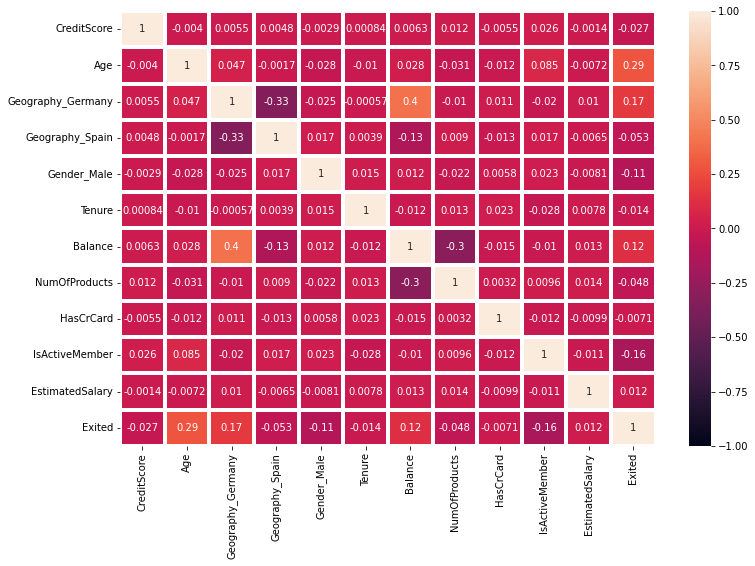

In [20]:
# looking for linear correlation between the variables using the pearson coefficient

# calculating the correlation matrix (returning the correlation between all the variables)
corr_matrix = df_2.corr()

# plotting the heatmap of the correlation matrix
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix,annot=True, linewidths=3, vmin=-1, vmax=1)
plt.show()

we can see that the highest correlation is between Germany and Balance, the highest correlation with the target, Exited, is Age.

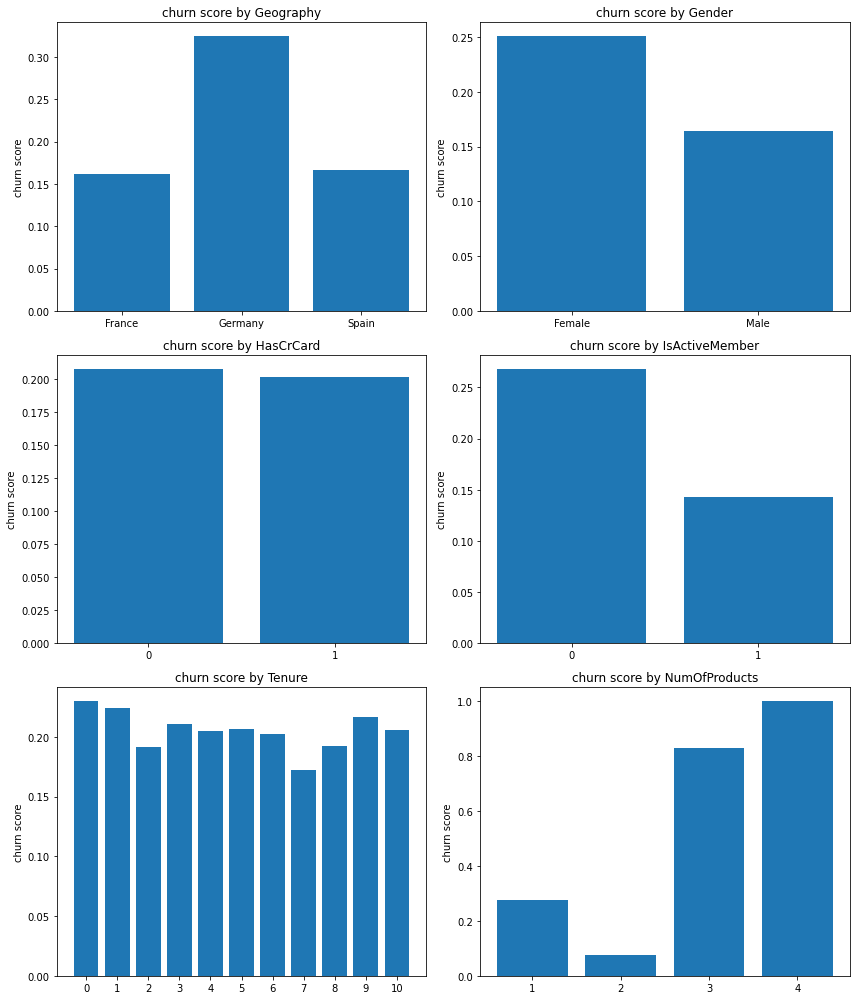

In [21]:
# plotting average churn score for each value in categorical and discrete variables in order to catch correlations between 
# those variables and the target 
cat_variables = ['Geography','Gender','HasCrCard','IsActiveMember','Tenure', 'NumOfProducts']

plt.subplots(3,2,figsize=(12,14))

for i in range(len(cat_variables)):
  plt.subplot(3,2,i+1)
  plt.bar(df_1.groupby(cat_variables[i]).agg({'Exited':'mean'}).index,df_1.groupby(cat_variables[i]).agg({'Exited':'mean'})['Exited'],width = 0.8)
  plt.ylabel(f'churn score')
  plt.xticks(df_1.groupby(cat_variables[i]).agg({'Exited':'mean'}).index)
  plt.title(f'churn score by {cat_variables[i]}')
  plt.tight_layout()

*  customers from Germany are more likely to churn than customers from France and Spain
*  it seems that women are more likely to churn than men
*  customers that don't have a credit card have the same probability to churn than those who have one
*   Non members are more likely to churn than members
*   Tenure doesn't seem to be predictive
*   It seems that the more products a customer uses the more he is likely to churn





In [22]:
# checking the number of records for each NumOfProducts
df_2['NumOfProducts'].value_counts()

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

we have a very few records for NumOfProducts equal to 3 and 4, so it is maybe non relevant to say that the more products we have the more likely a customer will Exit. We may have those numbers just by chance

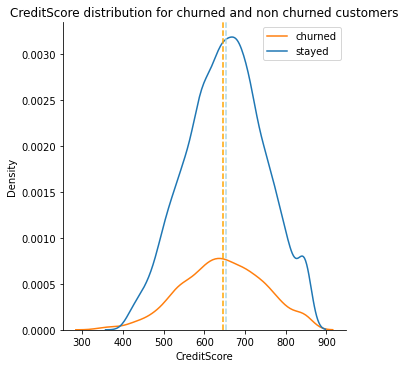

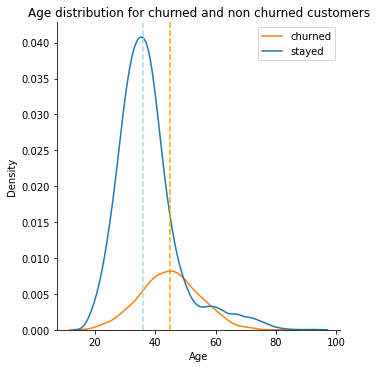

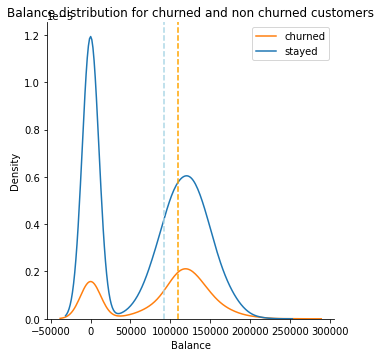

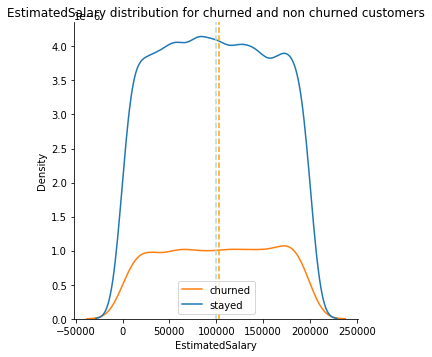

In [23]:
# now let's plot the distribution of the continuous numerical features for churned and non churned customers
# in order to capture if the variables may be predictive or not
num_variables = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']


for i in range(len(num_variables)):
  sns.displot(df_2,x=num_variables[i] , hue='Exited' , legend=False , kind ='kde')
  plt.title(f'{num_variables[i]} distribution for churned and non churned customers')
  # drawing vertical lines for the numerical variable mean and mode for churned customers
  plt.axvline(df_2[df_2.Exited==1][num_variables[i]].median() , linestyle='--' , color='orange')
  # drawing vertical lines for the numerical variable mean and mode for non churned customers
  plt.axvline(df_2[df_2.Exited==0][num_variables[i]].median(),linestyle = '--' , color='lightblue')
  plt.legend(['churned','stayed'])
  #plt.tight_layout()

Distributions of CreditScore and EstimatedSalary are likely the same for Exited and Stayed customers which means that the power of prediction of these variables is more likely to be very low or null. Distributions of Age and Balance are a little different between Exited and Stayed customers, these features should be predictive.

## **Modeling**

Our objective now is to try different models with different parameters in order to choose our final best model. But what is the best metric in our case that will allow us to compare and find the best model ?
In a business stand point I usually work within the expected value framework meaning that we first need to know what are the benefits of a good classification and the costs of a missclassification and according to the different models predictions compare the expected values and select the model that is bringing the most value to the business. In our case we don't have the benefits and the costs so we need to make the assumption that it is more critical for the business to find potential churner and also that churners predicted as non churners (False Negative) have a greater impact on the business than non churners predicted as churners (False Positive).
In conclusion we will focus on the recall score in order to compare our different models. 

we will try here the following models

*   Logistic Regression
*   KNN
*   SVM
*   Random Forest
*   XGBoost







In [26]:
# defining the variables and the target
X = df_2.iloc[:,:-1]
y = df_2.iloc[:,-1]

In [27]:
# splitting the data into train and test sets
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3 , shuffle=True , stratify=y , random_state=42)

In [28]:
# now let's run different models and pick the best one using pipelines
# in this pipelines we will use Synthetic Minority Oversampling Technique SMOTE to rebalance the classes in our data
# usually SMOTE performs better when combined with undersampling so we are going to oversample the minorty class and undersample the majority one

# importing the needed libraries

# pipeline
from imblearn.pipeline import Pipeline

# gridsearch to search over multiple parameters
from sklearn.model_selection import GridSearchCV

# SMOTE for oversampling the minority class
from imblearn.over_sampling import SMOTE

# RandomUnderSampler for undersampling the majority class
from imblearn.under_sampling import RandomUnderSampler

# scaling the data 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# cross validation library
from sklearn.model_selection import cross_val_score

# confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score , recall_score , precision_score , roc_curve


# importing models libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

1 - Logistic Regression

In [55]:
estimators_log = [('scale',StandardScaler()),('oversample',SMOTE()),('undersample',RandomUnderSampler()),('model', LogisticRegression())]

pipe_log = Pipeline(estimators_log)

param_grid_log = [
{'scale': [None,StandardScaler(),MinMaxScaler(),RobustScaler()]},
{'oversample': [SMOTE(random_state=42)],
 # setting the sizes of minority and majority classes samples when oversampling
 'oversample__sampling_strategy':[0.3,0.4,0.45,0.5]}, 
{'undersample':[RandomUnderSampler(random_state=42)],
 'undersample__sampling_strategy':[1]},
{'model':[LogisticRegression(random_state=42)],
 'model__C':[0.001, 0.01, 0.1, 1, 10, 100]}
]

#searching over the parameters in the pipeline by using GridSearchCV
grid_log = GridSearchCV(pipe_log, param_grid_log, cv=5, n_jobs=-1,verbose=1,scoring='recall',refit=True)

# best found model, based on its cross-validation score (here is the Recall) in the grid search
fittedgrid_log = grid_log.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [56]:
# returning the best estimator
fittedgrid_log.best_estimator_

Pipeline(steps=[('scale', StandardScaler()), ('oversample', SMOTE()),
                ('undersample', RandomUnderSampler()),
                ('model', LogisticRegression(C=0.001, random_state=42))])

In [57]:
fittedgrid_log.best_params_

{'model': LogisticRegression(C=0.001, random_state=42), 'model__C': 0.001}

In [58]:
# returning the confusion matrix
y_pred_log = fittedgrid_log.best_estimator_.predict(X_test)
confusion_matrix_log = pd.DataFrame(data = confusion_matrix(y_test,y_pred_log), columns=[0,1])
display(confusion_matrix_log)

# accuracy score for test data with our best estimator 
log_accuracy_score = accuracy_score(y_test, y_pred_log)
print(f'\n- accuracy score for our best logistic Regression model is {log_accuracy_score.round(3)}')
# recall score for test data with our best estimator 
log_recall_score = recall_score(y_test, y_pred_log)
print(f'- recall score for our best logistic Regression model is {log_recall_score.round(3)}')
# precision score for test data with our best estimator 
log_precision_score = precision_score(y_test, y_pred_log)
print(f'- precision score for our best logistic Regression model is {log_precision_score.round(3)}')

,0,1
0,1716,673
1,171,440



- accuracy score for our best logistic Regression model is 0.719
- recall score for our best logistic Regression model is 0.72
- precision score for our best logistic Regression model is 0.395


2 - KNN

In [60]:
estimators_KNN = [('scale',StandardScaler()),('oversample',SMOTE()),('undersample',RandomUnderSampler()),('model', KNeighborsClassifier())]

pipe_KNN = Pipeline(estimators_KNN)

param_grid_KNN = [
{'scale': [None,StandardScaler(),MinMaxScaler(),RobustScaler()]},
{'oversample': [SMOTE(random_state=42)],
 # setting the sizes of minority and majority classes samples when oversampling
 'oversample__sampling_strategy':[0.3,0.4,0.45,0.5]}, 
{'undersample':[RandomUnderSampler(random_state=42)],
 'undersample__sampling_strategy':[1]},
{'model':[KNeighborsClassifier()],
 'model__n_neighbors':[3,5,7,9]}
]

#searching over the parameters in the pipeline by using GridSearchCV
grid_KNN = GridSearchCV(pipe_KNN, param_grid_KNN, cv=5, n_jobs=-1,verbose=1,scoring='recall')

# best found model, based on its cross-validation score (here is the Recall) in the grid search
fittedgrid_KNN = grid_KNN.fit(X_train, y_train)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


In [61]:
# returning the best estimator
fittedgrid_KNN.best_estimator_

Pipeline(steps=[('scale', StandardScaler()),
                ('oversample', SMOTE(random_state=42, sampling_strategy=0.3)),
                ('undersample', RandomUnderSampler()),
                ('model', KNeighborsClassifier())])

In [62]:
# returning the confusion matrix
y_pred_KNN = fittedgrid_KNN.best_estimator_.predict(X_test)
confusion_matrix_KNN = pd.DataFrame(data = confusion_matrix(y_test,y_pred_KNN), columns=[0,1])
display(confusion_matrix_KNN)

# accuracy score for test data with our best estimator 
KNN_accuracy_score = accuracy_score(y_test, y_pred_KNN)
print(f'\n- accuracy score for our best KNN model is {KNN_accuracy_score.round(3)}')
# recall score for test data with our best estimator 
KNN_recall_score = recall_score(y_test, y_pred_KNN)
print(f'- recall score for our best KNN model is {KNN_recall_score.round(3)}')
# precision score for test data with our best estimator 
KNN_precision_score = precision_score(y_test, y_pred_KNN)
print(f'- precision score for our best KNN model is {KNN_precision_score.round(3)}')

,0,1
0,1736,653
1,186,425



- accuracy score for our best KNN model is 0.72
- recall score for our best KNN model is 0.696
- precision score for our best KNN model is 0.394


3 - SVM

In [63]:
estimators_SVM = [('scale',StandardScaler()),('oversample',SMOTE()),('undersample',RandomUnderSampler()),('model', SVC())]

pipe_SVM = Pipeline(estimators_SVM)

param_grid_SVM = [
{'scale': [None,StandardScaler(),MinMaxScaler(),RobustScaler()]},
{'oversample': [SMOTE(random_state=42)],
 # setting the sizes of minority and majority classes samples when oversampling
 'oversample__sampling_strategy':[0.3,0.4,0.45,0.5]}, 
{'undersample':[RandomUnderSampler(random_state=42)],
 'undersample__sampling_strategy':[1]},
{'model':[SVC(random_state=42)],
 'model__C':[0.001, 0.01, 0.1, 1, 10, 100],
 'model__kernel':['linear','rbf','poly']}
]

#searching over the parameters in the pipeline by using GridSearchCV
grid_SVM = GridSearchCV(pipe_SVM, param_grid_SVM, cv=5, n_jobs=-1,verbose=1,scoring='recall',refit=True)

# best found model, based on its cross-validation score (here is the Recall) in the grid search
fittedgrid_SVM = grid_SVM.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [64]:
# returning the best estimator
fittedgrid_SVM.best_estimator_

Pipeline(steps=[('scale', StandardScaler()),
                ('oversample', SMOTE(random_state=42, sampling_strategy=0.3)),
                ('undersample', RandomUnderSampler()), ('model', SVC())])

In [65]:
# returning the confusion matrix
y_pred_SVM = fittedgrid_SVM.best_estimator_.predict(X_test)
confusion_matrix_SVM = pd.DataFrame(data = confusion_matrix(y_test,y_pred_SVM), columns=[0,1])
display(confusion_matrix_SVM)


# accuracy score for test data with our best estimator 
SVM_accuracy_score = accuracy_score(y_test, y_pred_SVM)
print(f'\n- accuracy score for our best SVM model is {SVM_accuracy_score.round(3)}')
# recall score for test data with our best estimator 
SVM_recall_score = recall_score(y_test, y_pred_SVM)
print(f'- recall score for our best SVM model is {SVM_recall_score.round(3)}')
# precision score for test data with our best estimator 
SVM_precision_score = precision_score(y_test, y_pred_SVM)
print(f'- precision score for our best SVM model is {SVM_precision_score.round(3)}')

,0,1
0,1885,504
1,149,462



- accuracy score for our best SVM model is 0.782
- recall score for our best SVM model is 0.756
- precision score for our best SVM model is 0.478


Random Forest

In [66]:
estimators_RF = [('scale',StandardScaler()),('oversample',SMOTE()),('undersample',RandomUnderSampler()),('model', RandomForestClassifier())]

pipe_RF = Pipeline(estimators_RF)

param_grid_RF = [
{'scale': [None,StandardScaler(),MinMaxScaler(),RobustScaler()]},
{'oversample': [SMOTE(random_state=42)],
 # setting the sizes of minority and majority classes samples when oversampling
 'oversample__sampling_strategy':[0.3,0.4,0.45,0.5]}, 
{'undersample':[RandomUnderSampler(random_state=42)],
 'undersample__sampling_strategy':[1]},
{'model':[RandomForestClassifier(random_state=42)],
 'model__n_estimators':[100,200,500, 1000, 1500],
 'model__criterion':['gini','entropy']}
]

#searching over the parameters in the pipeline by using GridSearchCV
grid_RF = GridSearchCV(pipe_RF, param_grid_RF, cv=5, n_jobs=-1,verbose=1,scoring='recall',refit=True)

# best found model, based on its cross-validation score (here is the Recall) in the grid search
fittedgrid_RF = grid_RF.fit(X_train, y_train)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [67]:
# returning the parameters of the best estimator
fittedgrid_RF.best_estimator_

Pipeline(steps=[('scale', StandardScaler()),
                ('oversample', SMOTE(random_state=42, sampling_strategy=0.3)),
                ('undersample', RandomUnderSampler()),
                ('model', RandomForestClassifier())])

In [68]:
# returning the confusion matrix
y_pred_RF = fittedgrid_RF.best_estimator_.predict(X_test)
confusion_matrix_RF = pd.DataFrame(data = confusion_matrix(y_test,y_pred_RF), columns=[0,1])
display(confusion_matrix_RF)

# accuracy score for test data with our best estimator 
RF_accuracy_score = accuracy_score(y_test, y_pred_RF)
print(f'\n- accuracy score for our best RF model is {RF_accuracy_score.round(3)}')
# recall score for test data with our best estimator 
RF_recall_score = recall_score(y_test, y_pred_RF)
print(f'recall score for our best Random Forest model is {RF_recall_score.round(3)}')
# precision score for test data with our best estimator 
RF_precision_score = precision_score(y_test, y_pred_RF)
print(f'precision score for our best Random Forest model is {RF_precision_score.round(3)}')

,0,1
0,1917,472
1,147,464



- accuracy score for our best RF model is 0.794
recall score for our best Random Forest model is 0.759
precision score for our best Random Forest model is 0.496


XGBoost

In [69]:
estimators_XGB = [('scale',StandardScaler()),('oversample',SMOTE()),('undersample',RandomUnderSampler()),('model', XGBClassifier())]

pipe_XGB = Pipeline(estimators_XGB)

param_grid_XGB = [
{'scale': [None,StandardScaler(),MinMaxScaler(),RobustScaler()]},
{'oversample': [SMOTE(random_state=42)],
 # setting the sizes of minority and majority classes samples when oversampling
 'oversample__sampling_strategy':[0.3,0.4,0.45,0.5]}, 
{'undersample':[RandomUnderSampler(sampling_strategy=1 , random_state=42)]},
{'model':[XGBClassifier()],
 'model__n_estimators':[500, 1000, 1500],
 'model__label':X_train.columns.values,
 'model__learning_rate':[0.01,0.1,1]}
]

#searching over the parameters in the pipeline by using GridSearchCV
grid_XGB = GridSearchCV(pipe_XGB, param_grid_XGB, cv=5, n_jobs=-1,verbose=1,scoring='recall',refit=True)

# best found model, based on its cross-validation score (here is the Recall) in the grid search
fittedgrid_XGB = grid_XGB.fit(X_train.values, y_train.values)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [70]:
# returning the parameters of the best estimator
fittedgrid_XGB.best_estimator_

Pipeline(steps=[('scale', StandardScaler()),
                ('oversample', SMOTE(random_state=42, sampling_strategy=0.3)),
                ('undersample', RandomUnderSampler()),
                ('model', XGBClassifier())])

In [71]:
# returning the confusion matrix
y_pred_XGB = fittedgrid_XGB.best_estimator_.predict(X_test.values)
confusion_matrix_XGB = pd.DataFrame(data = confusion_matrix(y_test.values,y_pred_XGB), columns=[0,1])
display(confusion_matrix_XGB)

# accuracy score for test data with our best estimator 
XGB_accuracy_score = accuracy_score(y_test, y_pred_XGB)
print(f'\n- accuracy score for our best XGBoost model is {SVM_accuracy_score.round(3)}')
# recall score for test data with our best estimator 
XGB_recall_score = recall_score(y_test.values, y_pred_XGB)
print(f'recall score for our best XG Boost model is {XGB_recall_score.round(3)}')
# precision score for test data with our best estimator 
XGB_precision_score = precision_score(y_test, y_pred_XGB)
print(f'precision score for our best XGBoost model is {XGB_precision_score.round(3)}')

,0,1
0,1894,495
1,118,493



- accuracy score for our best XGBoost model is 0.782
recall score for our best XG Boost model is 0.807
precision score for our best XGBoost model is 0.499


# Summary

In [72]:
# summary tables
summary_table = pd.DataFrame({'model':['Logistic Regression','KNN','SVM','Random Forest','XGBoost'],
                              'accuracy':[log_accuracy_score,KNN_accuracy_score,SVM_accuracy_score,RF_accuracy_score,XGB_accuracy_score],
                          'recall':[log_recall_score,KNN_recall_score,SVM_recall_score,RF_recall_score,XGB_recall_score],
                          'precision':[log_precision_score,KNN_precision_score,SVM_precision_score,RF_precision_score,XGB_precision_score]})
print("summary table")
summary_table

summary table


,model,accuracy,recall,precision
0,Logistic Regression,0.718667,0.720131,0.395328
1,KNN,0.720333,0.695581,0.394249
2,SVM,0.782333,0.756137,0.478261
3,Random Forest,0.793667,0.759411,0.495726
4,XGBoost,0.795667,0.806874,0.498988


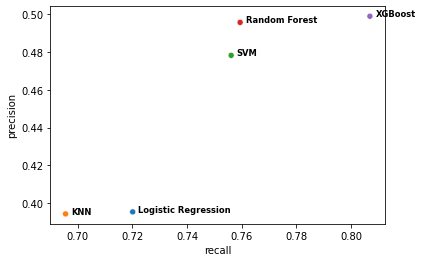

In [75]:
plt.figure()
sns.scatterplot(data = summary_table,x='recall',y='precision', hue='model', legend=False)


# adding annotations in the scatterplot
for i in range(0,summary_table.shape[0]):
     plt.text(summary_table.recall[i]+0.002, summary_table.precision[i], summary_table.model[i],
              horizontalalignment='left', size='small', color='black', weight='semibold')

the XGBoost is the model that has the best recall score moreover it has also the best precision score and best overall accuracy.

ROC AUC

The Area Under the ROC Curve is a good general summary statistic of the predictiveness of a classifier. A value of 0.5 corresponds to randomness, meaning that the classifier cannot distinguish at all between positives and negatives and a value of one means that it is perfect in distinguishing them. Let's see what we get with our models.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.wa

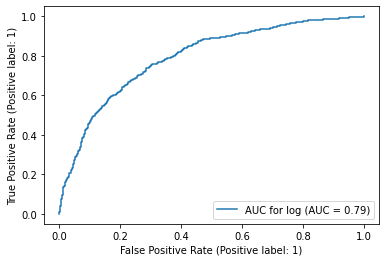

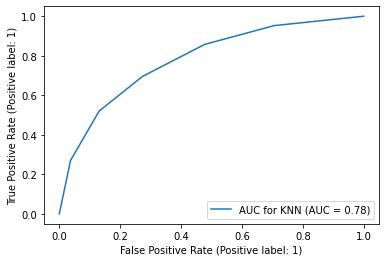

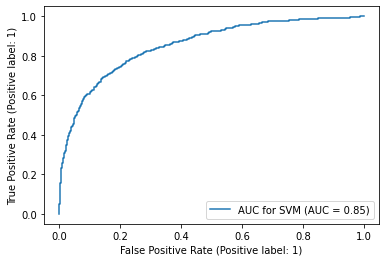

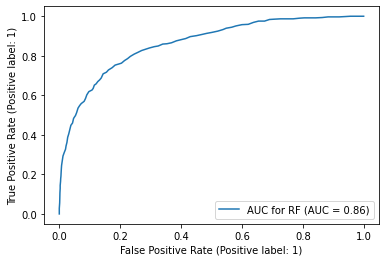

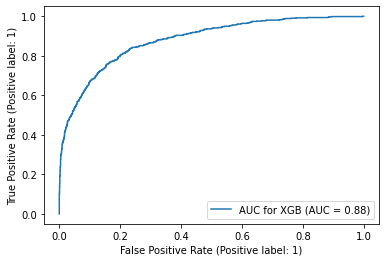

In [74]:
# calculating and plotting the AUC
from sklearn.metrics import plot_roc_curve

estimators = {'log':fittedgrid_log.best_estimator_,'KNN':fittedgrid_KNN.best_estimator_,'SVM':fittedgrid_SVM.best_estimator_,
              'RF':fittedgrid_RF.best_estimator_,'XGB':fittedgrid_XGB.best_estimator_}

for estimator in estimators:
  plot_roc_curve(estimators[estimator],X_test,y_test,name= 'AUC for '+estimator)

XGBoost has the best AUC which confirms our previous conclusion